## Milestone 2 Part A 

---

The main goal of this milestone is to perform a classification with LSTM on the dataset assigned to your group.

The outcome of this milestone is to design, implement, and refine a LSTM machine learning model using Keras' LSTM to predict a given gesture.

The following pair of gesture datasets are assigned to 

(a) Turn left and turn right: Team #4

b) Turn  and circle : Team #3

c) Stop  and no : Team #2

d) Hello  and abort : Team #1

### Main tasks
1) Prepare the polar angle dataset so that it is ready for Keras LSTM model

1.1) Format and prepare the data and randomly split it into 80% for training and 20% for testing

1.2) Prepare your training datasets, name them as X_train.txt and y_train.txt, and then put them under the data/data_for_lstm/train 

1.3) Prepare your testing datasets, name them as X_train.txt and y_train.txt, and then put them under the data/data_for_lstm/test 

2) Create a LSTM model with Keras

2.1) Vary the number of LSTM and layers and comment on how this would affect the gesture classification rate

2.2) Vary the dropout rate(s) to see how this would affect the gesture classification rate and the CPU time taken to execute the process.

3) Repeat (1) - (2) with the polar angular velocity dataset

4) Repeat (1) - (2) with both the polar angle and the polar angular velocity datasets

5) Comment, with reasons, on (1)-(4)


**Please provide the online discussion forum info here**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Everyone must put the copied folder in the exact path shown below so you collaborate and get graded easily.   
**No project score will be given for not following this folder configuration**    
(Our grader is *not reponsible to figure out your own* perferred Google *folder* configuration)   
**Only LSTM using Keras should be used in this milestone**

- Import libraries and models needed for this work

In [2]:
import numpy as np
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Masking
from keras import backend
from keras.utils.np_utils import to_categorical
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import json
import time
import pandas as pd

# Utility functions

In [3]:
# Helper Function to set MIN_NUM_FRAMES
# Parameter is an array of string, i.e. ['circle', 'turn', ...]
def get_min_frames(gestures):
  min_frame = 0
  for gesture in gestures:
    tmp = load_files(gesture)
    for video in tmp:
      if len(video) > min_frame:
        min_frame = len(video)
  return min_frame

#print(get_min_frames(['circle','turn']))

In [4]:
# function that loads all files under a <gesture> folder
def load_files(gesture):
  video = []
  filenames = os.listdir(os.path.join("./drive/My Drive/CS256Project/data/gestures_basic_d2", gesture))
  for filename in filenames:
    video.append(np.load(os.path.join('./drive/My Drive/CS256Project/data/gestures_basic_d2',gesture, filename), allow_pickle=True)['keypoints'])
  return video

In [5]:
def create_files(filepath):
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
  return dataframe.values

### Functions inherited from milestone 1

In [6]:
def updateCoord(frame):
  return frame - frame[0]
def getPolar(frame):
  tmp = []
  for i in range(1, len(frame)):
    tmp.append(np.arctan2(frame[i][1], frame[i][0]))
  return tmp
def getVelocity(polars):
  # the second dimension is 6 since we're just keeping the hand movements, which there will be 6 joints in total
  # Min_Joint and Max_Joint keep the indices of the joints we need
  velocity = [[MASK_VALUE for _ in range(MAX_JOINT - MIN_JOINT + 1)] for _ in range(len(polars))] #pad with mask value
  for frame in range(1, len(polars)):
    for joint in range(MAX_JOINT - MIN_JOINT + 1):
      velocity[frame][joint] = polars[frame][joint] - polars[frame-1][joint]
  return velocity

### A function that reads and transforms <gesture0> and <gesture1> to ready-to-train data

In [7]:
# Prepares features and target into the right format
def read_polar(gesture0, gesture1):
  X_0_raw = load_files(gesture0)
  X_0 = []
  for video in X_0_raw:
    polar = []
    for frame in range(len(video)):
      coord = video[frame][1][0].transpose(1, 0)
      polar.append(getPolar(updateCoord(coord))[MIN_JOINT:MAX_JOINT+1])
    velocity = getVelocity(polar)
    features = np.full((MIN_NUM_FRAMES, MAX_JOINT - MIN_JOINT + 1, 2), MASK_VALUE, dtype='float32') #pad with 1000 which is not in [-2pi, 2pi]
    features[:len(video), :, 0] = polar
    features[:len(video), :, 1] = velocity
    X_0.append(features)
  y_0 = [0 for _ in range(len(X_0))]

  X_1_raw = load_files(gesture1)
  X_1 = []
  for video in X_1_raw:
    polar = []
    for frame in range(len(video)):
      coord = video[frame][1][0].transpose(1, 0)
      polar.append(getPolar(updateCoord(coord))[MIN_JOINT:MAX_JOINT+1])
    velocity = getVelocity(polar)
    features = np.full((MIN_NUM_FRAMES, MAX_JOINT - MIN_JOINT + 1, 2), MASK_VALUE, dtype='float32') #pad
    features[:len(video), :, 0] = polar
    features[:len(video), :, 1] = velocity
    X_1.append(features)
  y_1 = [1 for _ in range(len(X_1))]

  return np.array(X_0 + X_1, dtype = 'float32'), np.array(y_0 + y_1)

# Global variables

In [8]:
root_path = "./drive/My Drive/CS256Project/data/data_for_lstm"
# MIN_JOINT ~ MAX_JOINT defines what joints the model will focus on
MIN_JOINT = 5
MAX_JOINT = 10
MIN_NUM_FRAMES = get_min_frames(['circle','turn']) #replace gestures if needed
MASK_VALUE = -1000
assert (os.path.exists(root_path)) #Checking if the data paths indeed exist and are valid.

# Prepare your X_train.txt, y_train.txt, X_test.txt, y_test.txt

In [9]:
X, y = read_polar('turn', 'circle')
# X will be storing m videos, each with n frames, while each frames have 17 joints
# y will be an array looking like [[0] * j, [1] * k] where j is the number of first gesture and k will be the number of second gesture

In [10]:
# Prepares traning and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# validate data read by their shape
print(f'Train set X shape: {np.array(X_train).shape}')
print(f'Test set X shape: {np.array(X_test).shape}')
print('N.B. #video, #frame, #joint, #feature')
print('-'*30)
print(f'Train set y length: {len(y_train)}')
print(f'Test set y length: {len(y_test)}')

Train set X shape: (98, 72, 6, 2)
Test set X shape: (25, 72, 6, 2)
N.B. #video, #frame, #joint, #feature
------------------------------
Train set y length: 98
Test set y length: 25


### Output txt file

In [ ]:
# reshapes them to 2D
X_train_2D = np.column_stack(list(map(np.ravel, np.meshgrid(*map(np.arange, X_train.shape), indexing="xy"))) + [X_train.ravel()])
X_test_2D = np.column_stack(list(map(np.ravel, np.meshgrid(*map(np.arange, X_test.shape), indexing="xy"))) + [X_test.ravel()])

# Converts all datasets to pandas dataframes

# X train
X_train_dataframe = pd.DataFrame(X_train_2D, columns=['video_id', 'frame_id', 'joint', 'polar', 'value'])
X_train_dataframe['polar'] = ['angle' if x == 0 else 'velocity' for x in X_train_dataframe['polar']]
X_train_dataframe = X_train_dataframe.astype({'video_id': int, 'frame_id': int, 'joint': int})

# X test
X_test_dataframe = pd.DataFrame(X_test_2D, columns=['video_id', 'frame_id', 'joint', 'polar', 'value'])
X_test_dataframe['polar'] = ['angle' if x == 0 else 'velocity' for x in X_test_dataframe['polar']]
X_test_dataframe = X_test_dataframe.astype({'video_id': int, 'frame_id': int, 'joint': int})

y_train_dataframe = pd.DataFrame(y_train, columns=['gesture'])
y_test_dataframe = pd.DataFrame(y_test, columns=['gesture'])

X_train_dataframe.head(6)

# Converts dataframes to JSON
X_train_JSON = X_train_dataframe.to_json(orient="index")
X_test_JSON = X_test_dataframe.to_json(orient="index")
y_train_JSON = y_train_dataframe.to_json(orient="index")
y_test_JSON = y_test_dataframe.to_json(orient="index")

json.dumps(json.loads(X_train_JSON))

## Another implementation (save file to designated folder)

In [15]:
def output_to_txt(X_train, X_test, y_train, y_test, folder = './drive/My Drive/CS256Project/data/data_for_lstm/'):
  X_train_output_filename = folder + 'train/X_train.txt'
  with open(X_train_output_filename, 'w', encoding='utf8') as f:
    for video_i in range(len(X_train)):
      f.write(f'"video{video_i}": {{\n')
      for frame_i in range(len(X_train[video_i])):
        f.write(f'\t"frame{frame_i}": {{\n')
        for joint_i in range(len(X_train[video_i][frame_i])):
          f.write(f'\t\t"joint{MIN_JOINT + joint_i}": {{\n')
          f.write(f'\t\t\t"polar": {X_train[video_i][frame_i][joint_i][0]}, \n')
          f.write(f'\t\t\t"velocity": {X_train[video_i][frame_i][joint_i][1]}\n')
          f.write(f'\t\t}}, \n')
        f.write(f'\t}}, \n')
      f.write(f'}}, \n')
  np.save(folder + 'train/X_train.npy', X_train, allow_pickle = True)

  y_train_output_filename = folder + 'train/y_train.txt'
  with open(y_train_output_filename, 'w', encoding='utf8') as f:
    for video_i in range(len(y_train)):
      f.write(f'"video{video_i}": {y_train[video_i]}, \n')
  np.save(folder + 'train/y_train.npy', y_train, allow_pickle = True)

  X_test_output_filename = folder + 'test/X_test.txt'
  with open(X_test_output_filename, 'w', encoding='utf8') as f:
    for video_i in range(len(X_train)):
      f.write(f'"video{video_i}": {{\n')
      for frame_i in range(len(X_train[video_i])):
        f.write(f'\t"frame{frame_i}": {{\n')
        for joint_i in range(len(X_train[video_i][frame_i])):
          f.write(f'\t\t"joint{MIN_JOINT + joint_i}": {{\n')
          f.write(f'\t\t\t"polar": {X_train[video_i][frame_i][joint_i][0]}, \n')
          f.write(f'\t\t\t"velocity": {X_train[video_i][frame_i][joint_i][1]}\n')
          f.write(f'\t\t}}, \n')
        f.write(f'\t}}, \n')
      f.write(f'}}, \n')
  np.save(folder + 'test/X_test.npy', X_test, allow_pickle = True)

  y_test_output_filename = './drive/My Drive/CS256Project/data/data_for_lstm/test/y_test.txt'
  with open(y_test_output_filename, 'w', encoding='utf8') as f:
    for video_i in range(len(y_train)):
      f.write(f'"video{video_i}": {y_train[video_i]}, \n')
  np.save(folder + 'test/y_test.npy', y_train, allow_pickle = True)

In [16]:
output_to_txt(X_train, X_test, y_train, y_test)

# Evaluate model

In [17]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, neurons=50, drop_out_rate = 0.5, lstm_layers = 1, dropout_layers = 1, summary = True):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], 2
	model = Sequential()
	model.add(Masking(mask_value=MASK_VALUE, input_shape=(n_timesteps, n_features))) # Masking layer
	for _ in range(lstm_layers - 1):
		model.add(LSTM(neurons, input_length=trainX.shape[1], input_dim=trainX.shape[2], return_sequences = True))
	model.add(LSTM(neurons, input_length=trainX.shape[1], input_dim=trainX.shape[2]))
 
	for _ in range(dropout_layers):
		model.add(Dropout(drop_out_rate))
		model.add(Dense(100, activation='relu'))
	
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
	# fit network
	if(summary):
		model.summary()
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
	return accuracy

## Test out different hyper paramenter for training with polar angle

In [ ]:
# Clears backend keras session: https://stackoverflow.com/questions/55299510/cpu-usage-and-time-until-training-starts-increasing-on-each-model-fit-in-keras/55300684
backend.clear_session()

print('+-----------+')
print('|Polar angle|')
print('+-----------+')
Polar_train, Polar_test = X_train[:, :, :, 0], X_test[:, :, :, 0]
plot_num_neurons, accuracy = [], []
for neurons in range(50, 1001, 50):
  plot_num_neurons.append(neurons)
  backend.clear_session()
  acc = evaluate_model(Polar_train, y_train, Polar_test, y_test, neurons = neurons, drop_out_rate = 0.5, lstm_layers= 1, dropout_layers = 1, summary = False)
  accuracy.append(acc)

plt.subplot(1, 4, 1) # row 1, col 2 index 1
plt.plot(plot_num_neurons, accuracy)
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')


plot_dropout, accuracy = [], []
for dropout_rate in np.arange(0.0, 1.0, 0.1):
  plot_dropout.append(dropout_rate)
  backend.clear_session()
  acc = evaluate_model(Polar_train, y_train, Polar_test, y_test, neurons = 50, drop_out_rate = dropout_rate, lstm_layers= 1, dropout_layers = 1, summary = False)
  accuracy.append(acc)

plt.subplot(1, 4, 2) # index 2
plt.plot(plot_dropout, accuracy)
plt.xlabel('Dropout rate')

plot_LSTM, accuracy = [], []
for layers in np.arange(1, 6, 1):
  plot_LSTM.append(layers)
  backend.clear_session()
  acc = evaluate_model(Polar_train, y_train, Polar_test, y_test, neurons = 50, drop_out_rate = 0.5, lstm_layers= layers, dropout_layers = 1, summary = False)
  accuracy.append(acc)
  
plt.subplot(1, 4, 3) # index 3
plt.plot(plot_LSTM, accuracy)
plt.xlabel('LSTM layers')

plot_dropout_layer, accuracy = [], []
for layers in np.arange(1, 6, 1):
  plot_dropout_layer.append(layers)
  backend.clear_session()
  # %%time
  acc = evaluate_model(Polar_train, y_train, Polar_test, y_test, neurons = 50, drop_out_rate = 0.5, lstm_layers= 1, dropout_layers = layers, summary = False)
  accuracy.append(acc)

plt.subplot(1, 4, 4) # index 4
plt.plot(plot_dropout_layer, accuracy)
plt.xlabel('Dropout layers')

plt.show()

In [ ]:
# commit: 'Changing #layer and #neuron'
print('+-----------+')
print('|Polar angle|')
print('+-----------+')
Polar_train, Polar_test = X_train[:, :, :, 0], X_test[:, :, :, 0]


lstm = []
# This configuration runs for around 2 hours. Change to a smaller generator if just testing.
layer_gen = range(1, 11)
neuron_gen = range(50, 1001, 30)
for layers in layer_gen:
  row = []
  print(layers, end = '')
  for neurons in tqdm(neuron_gen):
    backend.clear_session()
    acc = evaluate_model(Polar_train, y_train, Polar_test, y_test, neurons = neurons, drop_out_rate = 0.5, lstm_layers= layers, dropout_layers = 1, summary = False)
    row.append(acc)
  lstm.append(row)

plt.figure(figsize=(30, 10))
sns.heatmap(lstm, linewidth=0.5, xticklabels= [i for i in neuron_gen], yticklabels=[i for i in layer_gen], annot = True)
plt.xlabel('Neurons')
plt.ylabel('Layers')
plt.title('LSTM layer')
plt.savefig('./drive/My Drive/CS256Project/LSTM_layer_heatmap-20211114.png')
np.savetxt("./drive/My Drive/CS256Project/LSTM_layer-20211114.csv", lstm, delimiter=",")

## Test out different hyper paramenter for training with polar velocity

In [ ]:
# Explores trends from LSTM layers and neurons
# Models below used 0.5 dropout rate and 1 dense layer as default. 
# Observation: Classification accuracy is high on average within 5 LSTM layers; larger number of neurons may yield higher accuracy on average. 


backend.clear_session()
print('+--------------------+')
print('|Velocity LSTM&Neuron|')
print('+--------------------+')
Velocity_train, Velocity_test = X_train[:, :, :, 1], X_test[:, :, :, 1]

velocity = []
# Loops through numbers of LSTM layers and neurons to find an appropriate start configuration.
# No.LSTM layers 1-6 so that the model would not be too complex like shown in the angle result above.
layer_n = range(1, 6)
neuron_n = range(30, 211, 30)
for layers in layer_n:
  row = []
  print(layers, end = '')
  for neurons in tqdm(neuron_n):
    backend.clear_session()
    acc = evaluate_model(Velocity_train, y_train, Velocity_test, y_test, neurons = neurons, drop_out_rate = 0.5, lstm_layers= layers, dropout_layers = 1, summary = False)
    row.append(acc)
  velocity.append(row)

# Plots accuracy on heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(velocity, linewidth=0.5, xticklabels= [i for i in neuron_gen], yticklabels=[i for i in layer_gen], annot = True)
plt.xlabel('Neurons')
plt.ylabel('Layers')
plt.title('Accuracy')
plt.savefig('./drive/My Drive/Projects/LSTM_layer_heatmap-20211114.png')
np.savetxt("./drive/My Drive/Projects/LSTM_layer-20211115.csv", velocity, delimiter=",")

In [ ]:
# Explores trends from dropout rate and dense layer
# Models below used 5 LSTM layers and 150 neurons as they are among the region where classification is highly accurate on average.
# Observation: Classification accuracy may drop as we have too many dense layers; low dropout rates may yield better accuracy than high rates on average. 
# In some cases, high dropout rates increase CPU time while median dropout rates have the highest CPU times in other cases. 

backend.clear_session()
print('+----------------------+')
print('|Velocity Dropout&Dense|')
print('+----------------------+')
Velocity_train, Velocity_test = X_train[:, :, :, 1], X_test[:, :, :, 1]

accuracy_2 = []
cpu_time = []

dense_n = range(1, 6)
dropout_n = np.arange(0, 1, 0.1)
for dense in dense_n:
  row_accu = []
  row_time = []
  print(dense, end = '')
  for dropout in tqdm(dropout_n):
    backend.clear_session()
    start_time = time.process_time()
    acc = evaluate_model(Velocity_train, y_train, Velocity_test, y_test, neurons = 150, drop_out_rate = dropout, lstm_layers= 5, dropout_layers = dense, summary = False)
    end_time = time.process_time()
    row_accu.append(acc)
    row_time.append(end_time-start_time) # Records CPU time cost by building the model.
  accuracy_2.append(row_accu)
  cpu_time.append(row_time)


plt.figure(figsize=(30, 10))
sns.heatmap(accuracy_2, linewidth=0.5, xticklabels= [str(i)[:3] for i in dropout_n], yticklabels=[str(i)[:3] for i in dense_n], annot = True)
plt.xlabel('Dropout Rate')
plt.ylabel('Dense Layers')
plt.title('Accuracy')
plt.savefig('./drive/My Drive/Projects/Dense_layer_heatmap-20211116.png')
np.savetxt("./drive/My Drive/Projects/Dense_layer-20211115.csv", accuracy_2, delimiter=",")
np.savetxt("./drive/My Drive/Projects/Dense_layer_cpu-20211115.csv", cpu_time, delimiter=",")


plt.figure(figsize=(30, 10))
sns.heatmap(cpu_time, linewidth=0.5, xticklabels= [str(i)[:3] for i in dropout_n], yticklabels=[str(i)[:3] for i in dense_n], annot = True)
plt.xlabel('Dropout Rate')
plt.ylabel('Dense Layers')
plt.title('CPU Times')
plt.savefig('./drive/My Drive/Projects/Dense_layer_time_heatmap-20211116.png')

## Test out different hyper paramenter for training with polar angle and velocity

+-------------------+
|Angle and Velocity|
+-------------------+
Maximum accuracy(neurons): 150 neurons, 0.9599999785423279
Maximum accuracy(layers): 3 layers, 1.0
Maximum accuracy(dropout): 0.0 dropout rate, 0.9599999785423279


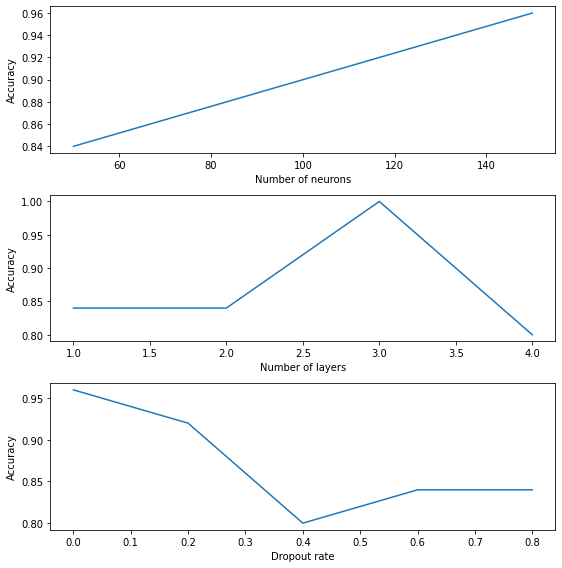

In [ ]:
backend.clear_session()
print('+-------------------+')
print('|Angle and Velocity|')
print('+-------------------+')

# -----------------------------------------------------------------------------
# Experiments on individual parameter's effect on classfication rate
# -----------------------------------------------------------------------------

# Concatnating the angles and velocities into a single array as 12 input 
# features for every frame
both_trainX = np.concatenate((X_train[:, :, :, 0], X_train[:, :, :, 1]), axis=2)
both_testX = np.concatenate((X_test[:, :, :, 0], X_test[:, :, :, 1]), axis=2)
both_trainX.shape

plot_neurons, acc_neurons = [], []
plot_layers, acc_layers = [], []
plot_dropout, acc_dropout = [], []

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
# ----------------------------------------------------------------
# Different number of neurons
# ----------------------------------------------------------------
for neurons in np.arange(50, 200, 100):
  acc_neurons.append(evaluate_model(both_trainX, y_train, both_testX, y_test, neurons=neurons, summary=False))
  plot_neurons.append(neurons)
axs[0].plot(plot_neurons, acc_neurons)
axs[0].set_xlabel('Number of neurons')
axs[0].set_ylabel('Accuracy')
max_index = np.argmax(acc_neurons)
print("Maximum accuracy(neurons): {} neurons, {}".format(plot_neurons[max_index], acc_neurons[max_index]))
backend.clear_session()


# ----------------------------------------------------------------
# Different number LSTM layers
# ----------------------------------------------------------------

for layers in np.arange(1, 5, 1):
  acc_layers.append(evaluate_model(both_trainX, y_train, both_testX, y_test, lstm_layers=layers, summary=False))
  plot_layers.append(layers)
axs[1].plot(plot_layers, acc_layers)
axs[1].set_xlabel('Number of layers')
axs[1].set_ylabel('Accuracy')
max_index = np.argmax(acc_layers)
print("Maximum accuracy(layers): {} layers, {}".format(plot_layers[max_index], acc_layers[max_index]))
backend.clear_session()

# ----------------------------------------------------------------
# Different Dropout
# ----------------------------------------------------------------

for rate in np.arange(0.0, 1 , 0.2):
  acc_dropout.append(evaluate_model(both_trainX, y_train, both_testX, y_test, drop_out_rate=rate, summary=False))
  plot_dropout.append(rate)
axs[2].plot(plot_dropout, acc_dropout)
axs[2].set_xlabel('Dropout rate')
axs[2].set_ylabel('Accuracy')

max_index = np.argmax(acc_dropout)
print("Maximum accuracy(dropout): {} dropout rate, {}".format(plot_dropout[max_index], acc_dropout[max_index]))


fig.tight_layout()

plt.show()

In [ ]:
# ----------------------------------------------------------------
# Experiment on dropout vs CPU time
# ----------------------------------------------------------------
def time_various_dropout():
  for rate in np.arange(0.0, 1.0, 0.2):
    print("Dropout rate = {}".format(rate))
    %time evaluate_model(both_trainX, y_train, both_testX, y_test, drop_out_rate=rate, neurons=150, lstm_layers=2, summary=False)
    print("----------------------------------------------------")

time_various_dropout()

Dropout rate = 0.0
CPU times: user 15.7 s, sys: 357 ms, total: 16 s
Wall time: 16.2 s
----------------------------------------------------
Dropout rate = 0.2
CPU times: user 15.6 s, sys: 327 ms, total: 15.9 s
Wall time: 16.1 s
----------------------------------------------------
Dropout rate = 0.4
CPU times: user 15.5 s, sys: 343 ms, total: 15.8 s
Wall time: 16 s
----------------------------------------------------
Dropout rate = 0.6000000000000001
CPU times: user 15.7 s, sys: 350 ms, total: 16 s
Wall time: 18.7 s
----------------------------------------------------
Dropout rate = 0.8
CPU times: user 15.5 s, sys: 388 ms, total: 15.9 s
Wall time: 16.1 s
----------------------------------------------------


In [ ]:
# ----------------------------------------------------------------
# Number of layers and neurons on classification 
# (This will take quite some time to load depending on how many 
#  layers and neurons specified)
# ----------------------------------------------------------------

lstm = []
layer_gen = range(1, 8) # Tune layers here
neuron_gen = range(20, 200, 20) # Tune neurons here
for layers in layer_gen:
  row = []
  print(layers, end = '')
  for neurons in tqdm(neuron_gen):
    backend.clear_session()
    acc = evaluate_model(both_trainX, y_train, both_testX, y_test, neurons = neurons, drop_out_rate = 0.5, lstm_layers= layers, dropout_layers = 1, summary = False)
    row.append(acc)
  lstm.append(row)

plt.figure(figsize=(30, 10))
sns.heatmap(lstm, linewidth=0.5, xticklabels= [i for i in neuron_gen], yticklabels=[i for i in layer_gen], annot = True)
plt.xlabel('Neurons')
plt.ylabel('Layers')
plt.title('LSTM layer')
plt.savefig('./drive/My Drive/LSTM_layer_heatmap-20211114.png')
np.savetxt("./drive/My Drive/LSTM_layer-20211114.csv", lstm, delimiter=",")

1

  0%|          | 0/9 [00:00<?, ?it/s]

2

  0%|          | 0/9 [00:00<?, ?it/s]

3

  0%|          | 0/9 [00:00<?, ?it/s]

4

  0%|          | 0/9 [00:00<?, ?it/s]

5

  0%|          | 0/9 [00:00<?, ?it/s]

### Analysis for Angle and Velocity
From running various experiments on different number of LSTM layers and neurons, maximum accuracy we achieved for training using angle and velocity is 100%. <br><br>
One model can achieve this is:<br>
Number of neurons = 80<br>
Number of layers = 2<br>
Dropout rate = 0.5 <br>
<br><br>
Another example: <br>
Number of neurons = 60<br>
Number of layers = 3<br>
Dropout rate = 0.5 <br><br>
Note, given the LSTM model is stochastic, result will vary on each run. However, generally trend we can observe is that if model is too complex, i.e. neurons > 400 & layers > 5, the classification rate decreases. Therefore, it is really important to run various experiments to find out the best machine learning model for the given dataset. 